In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Load the processed dataset
df = pd.read_csv('Dataset/train_processed.csv')
test_df = pd.read_csv('Dataset/test_processed.csv')

bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
bool_cols_test = test_df.select_dtypes(include='bool').columns
test_df[bool_cols_test] = test_df[bool_cols_test].astype(int)

In [97]:
# Compute pair frequency (A → B)
account_pairs = df.groupby(['From Account', 'To Account']).size().reset_index(name='pair_frequency')

# Compute reverse pair frequency (B → A)
reverse_pairs = account_pairs.copy()
reverse_pairs.columns = ['To Account', 'From Account', 'reverse_pair_frequency']  # flip column names

# Merge both into the original dataframe
df = df.merge(account_pairs, on=['From Account', 'To Account'], how='left')
df = df.merge(reverse_pairs, on=['From Account', 'To Account'], how='left')  # correct merge

# Fill missing frequencies
df['pair_frequency'].fillna(1, inplace=True)
df['reverse_pair_frequency'].fillna(0, inplace=True)

# Flag circular transactions
df['is_circular'] = (df['reverse_pair_frequency'] > 0).astype(int)

C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\1452891232.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pair_frequency'].fillna(1, inplace=True)
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\1452891232.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

In [98]:
# Compute pair frequency (A → B)
account_pairs = test_df.groupby(['From Account', 'To Account']).size().reset_index(name='pair_frequency')

# Compute reverse pair frequency (B → A)
reverse_pairs = account_pairs.copy()
reverse_pairs.columns = ['To Account', 'From Account', 'reverse_pair_frequency']  # flip column names

# Merge both into the original dataframe
test_df = test_df.merge(account_pairs, on=['From Account', 'To Account'], how='left')
test_df = test_df.merge(reverse_pairs, on=['From Account', 'To Account'], how='left')  # correct merge

# Fill missing frequencies
test_df['pair_frequency'].fillna(1, inplace=True)
test_df['reverse_pair_frequency'].fillna(0, inplace=True)

# Flag circular transactions
test_df['is_circular'] = (test_df['reverse_pair_frequency'] > 0).astype(int)

C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\3936049671.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['pair_frequency'].fillna(1, inplace=True)
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\3936049671.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [99]:
df = df.drop(columns=['From Account', 'To Account'], errors='ignore')


# Separate features and target
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [100]:
#!pip install optuna

In [101]:
test_df = test_df.drop(columns=['From Account', 'To Account'], errors='ignore')

In [102]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
import numpy as np
import optuna
import optuna.visualization as vis

def objective(trial): 
    # Handle class imbalance
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # LightGBM hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight,
        'force_col_wise': True,
        'verbosity': -1
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)

        # Predict fraud probabilities
        probas = model.predict_proba(X_fold_val)[:, 1]

        # Top X predictions: let’s capture the top ~3% (e.g. if val set = 5660, top_n = 169)
        top_n = int(0.03 * len(y_fold_val))
        top_indices = np.argsort(probas)[-top_n:]

        # Compute fraud capture rate (Recall@TopN)
        captured = y_fold_val.iloc[top_indices].sum()
        total = y_fold_val.sum()
        capture_rate = captured / total if total > 0 else 0
        scores.append(capture_rate)

    return np.mean(scores)

# Start optimization
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

# Best results
best_params = study.best_params
best_score = study.best_value

print("✅ Best Hyperparameters:", best_params)
print("🎯 Best Fraud Capture Rate @Top3%:", round(best_score * 100, 2), "%")


[I 2025-06-16 03:23:39,860] A new study created in memory with name: no-name-9fba1d3b-6e4f-4cff-8115-00f4955082b3
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\2918223393.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
[I 2025-06-16 03:23:41,227] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202}. Best is trial 0 with value: 1.0.
C:\Users\emanu\AppData\Local\Temp\ipykernel_23904\2918223393.py:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0.

KeyboardInterrupt: 

In [103]:
# Calculate scale_pos_weight (for handling class imbalance)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Inject into best_params
best_params = {
    'n_estimators': 218,
    'learning_rate': 0.01924315730262365,
    'max_depth': 14,
    'num_leaves': 39,
    'min_child_samples': 25,
    'subsample': 0.9614156550100574,
    'subsample_freq': 3,
    'colsample_bytree': 0.7963352256675209,
    'reg_alpha': 0.3944497642389667,
    'reg_lambda': 0.5504332251782049,
    'max_bin': 245,
    'scale_pos_weight': scale_pos_weight,
    'force_col_wise': True,
    'verbosity': -1
}

# Train the model
best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)

# Predict probabilities on test set
lgbm_probabilities = best_lgb_classifier.predict_proba(test_df)[:, 1]


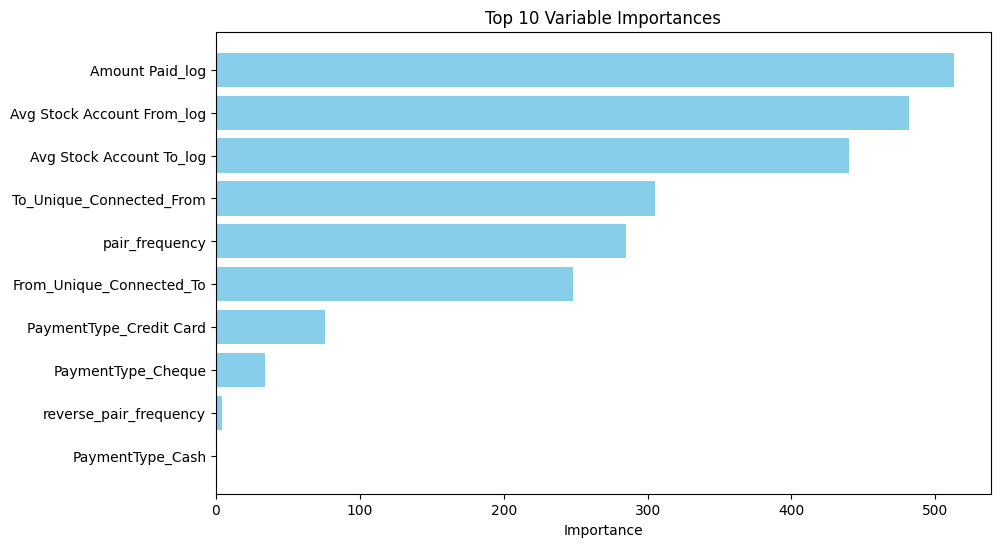

In [104]:
import matplotlib.pyplot as plt
# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  
plt.show()


In [105]:
lgbm_predictions = best_lgb_classifier.predict(test_df)

In [106]:
# Create DataFrame with required format
submission_df = pd.DataFrame({
    'prob(Fraud)': lgbm_probabilities,
    'prediction': lgbm_predictions
})

# Save as space-separated .txt file without header
submission_df.to_csv("submission.txt", index=False, sep=' ', header=False)


In [107]:
#count how many 1
print("Number of predicted fraud cases:", submission_df['prediction'].sum())

Number of predicted fraud cases: 304
